In [ ]:
#Mounting Dataset Segment
from google.colab import drive
import zipfile

drive.mount('/content/drive')

zip_file_path = "/content/drive/My Drive/Tabular Dataset ready for malicious url detection.zip"

try:
  with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall("/content") # Extracting to the current working directory
  print(f"Successfully extracted {zip_file_path} to /content")
except FileNotFoundError:
  print(f"Error: File not found at {zip_file_path}")
except zipfile.BadZipFile:
  print(f"Error: Invalid zip file at {zip_file_path}")
except Exception as e:
  print(f"An unexpected error occurred: {e}")


Mounted at /content/drive
Successfully extracted /content/drive/My Drive/Tabular Dataset ready for malicious url detection.zip to /content


In [ ]:
#Data Preprocessing Segment
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

# Loading the dataset
try:
    df = pd.read_csv('train_dataset.csv', nrows=20000) #Reading only 20000 rows to avoid session crasing due RAM restriction.
    df_test = pd.read_csv('test_dataset.csv', nrows=20000)
except FileNotFoundError:
    print("Error: Both or one of the dataset.csv not found. Please ensure the file is extracted correctly.")
    exit()

# Checking for missing values and handle them
df = df.fillna(0)  # Filling missing values with 0
df_test = df_test.fillna(0)

# Identifying categorical (string) and numerical columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

categorical_cols_test = df_test.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols_test = df_test.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Removing 'label' from these lists if present
if 'label' in categorical_cols:
    categorical_cols.remove('label')
if 'label' in numerical_cols:
    numerical_cols.remove('label')

if 'label' in categorical_cols_test:
    categorical_cols_test.remove('label')
if 'label' in numerical_cols_test:
    numerical_cols_test.remove('label')

# Data preprocessing
X_train = df.drop('label', axis=1)
y_train = df['label']

X_test = df_test.drop('label', axis=1)
y_test = df_test['label']

# Createing preprocessing pipelines for both numerical and categorical data
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combining preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Applying preprocessing
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Converting sparse matrix to dense
if hasattr(X_train_processed, "toarray"):
    X_train_processed = X_train_processed.toarray()
if hasattr(X_test_processed, "toarray"):
    X_test_processed = X_test_processed.toarray()

# Converting y to numpy array
y_train = np.array(y_train)


Ratio of malicious to non-malicious URLs in the training dataset: 0.2723


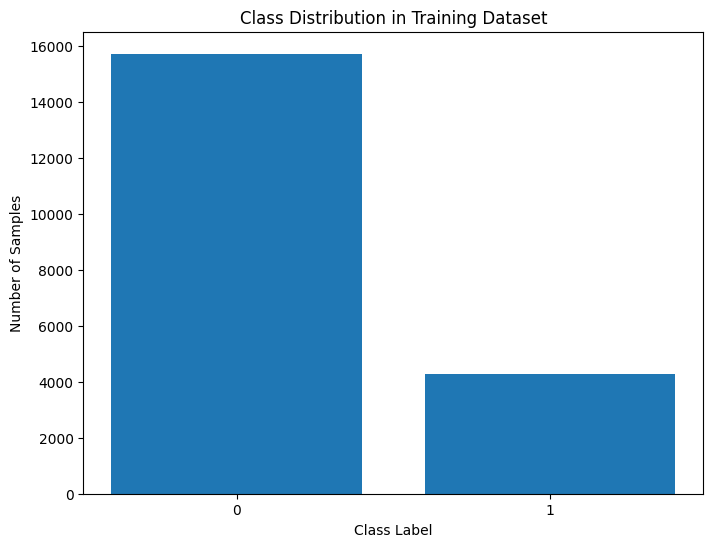

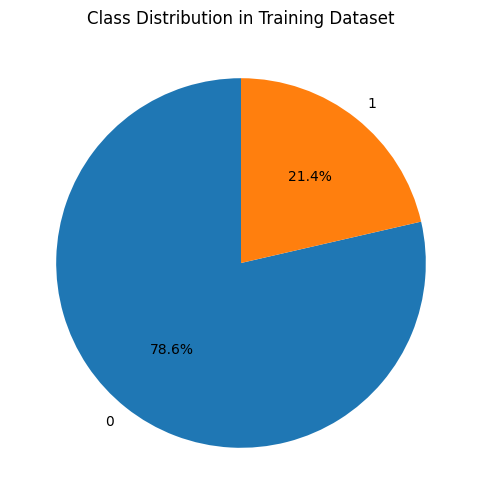

In [ ]:
#Data distirbution visualization to determine class imbalance
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Wrapping y_train in a Pandas Series to use value_counts()
class_counts = pd.Series(y_train).value_counts()

# Calculating and printing the ratio - Helps to determine the class weight adjusment later on
malicious_count = class_counts[1]
non_malicious_count = class_counts[0]
ratio = malicious_count / non_malicious_count
print(f"Ratio of malicious to non-malicious URLs in the training dataset: {ratio:.4f}")

# Creating a bar plot
plt.figure(figsize=(8, 6))
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Training Dataset')
plt.xticks(class_counts.index)
plt.show()

# Creating a pie chart
plt.figure(figsize=(6, 6))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Class Distribution in Training Dataset')
plt.show()

In [ ]:

# Logistic Regression Algorithm Definition with Gradient Descent
class LogisticRegression:
    def __init__(self, learning_rate=0.001, n_iters=5000,class_weights={0: 0.637, 1: 2.326}): #Class weights were calculated based on class imblanced ratio
        self.lr = learning_rate
        self.n_iters = n_iters
        self.class_weights = class_weights  #Cost Sensitive learning approach 1 - Modified class weights to address class imbalance.
        self.weights = None
        self.bias = None
        self.losses = []

    #Loss function -  Weighted Binary Cross-Entropy Function
    def _calculate_loss(self, y_true, y_predicted, sample_weights=None):
      epsilon = 1e-15
      y_predicted = np.clip(y_predicted, epsilon, 1-epsilon)

      if sample_weights is None:
          sample_weights = np.ones(len(y_true))

      loss = -np.mean(sample_weights * (y_true * np.log(y_predicted) +
                    (1-y_true) * np.log(1-y_predicted)))
      return loss

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        sample_weights = np.array([self.class_weights[int(label)] for label in y])

        # Added early stopping to prevent overfitting
        best_loss = float('inf')
        patience = 5
        patience_counter = 0

        for i in range(self.n_iters):
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self._sigmoid(linear_model)

            # Applying weights to the gradient calculation
            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y) * sample_weights)
            db = (1 / n_samples) * np.sum((y_predicted - y) * sample_weights)

            self.weights -= self.lr * dw
            self.bias -= self.lr * db

            loss = self._calculate_loss(y, y_predicted, sample_weights)
            self.losses.append(loss)

            # Early stopping logic
            if loss < best_loss:
                best_loss = loss
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print(f"Early stopping at epoch {i+1}")
                break

    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = self._sigmoid(linear_model)
        y_predicted_cls = [1 if i > 0.48 else 0 for i in y_predicted] #Changed the classification threshold to 0.48 for more balanced prediction
        return np.array(y_predicted_cls)

    def _sigmoid(self, x):
        # Cliping x to prevent overflow
        x = np.clip(x, -500, 500)
        return 1 / (1 + np.exp(-x))

    def accuracy(self, X, y):
        y_pred = self.predict(X)
        return np.sum(y_pred == y) / len(y)


In [ ]:
# Model Training Segment
model = LogisticRegression(learning_rate=0.005, n_iters=10000,class_weights={0: 0.637, 1: 2.326})
model.fit(X_train_processed, y_train)

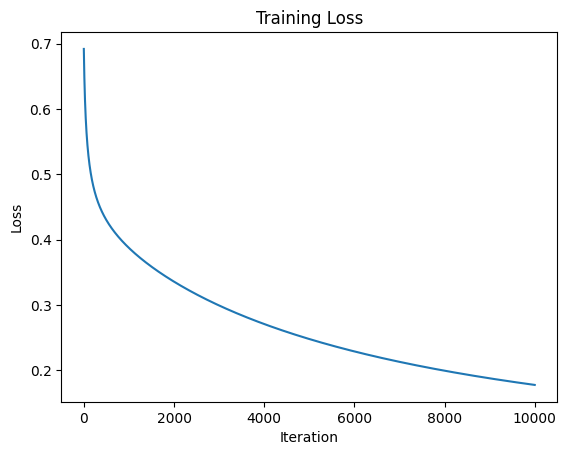

In [ ]:
#visualizing loss
import matplotlib.pyplot as plt

plt.plot(model.losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()



Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     15638
           1       0.90      0.97      0.93      4362

    accuracy                           0.97     20000
   macro avg       0.95      0.97      0.96     20000
weighted avg       0.97      0.97      0.97     20000



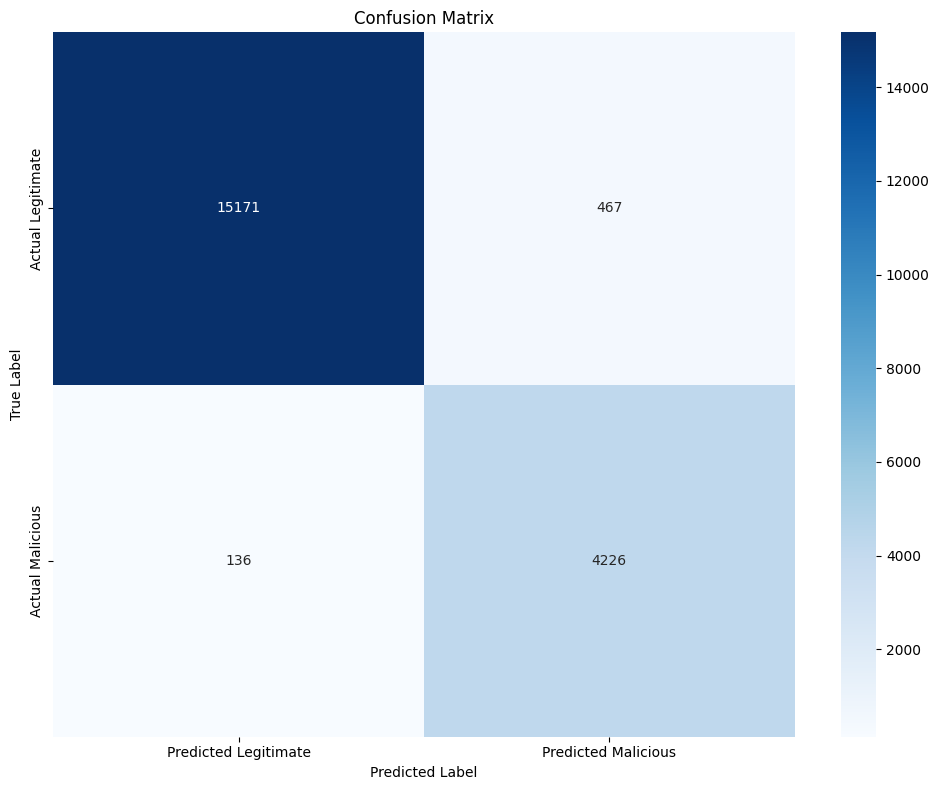

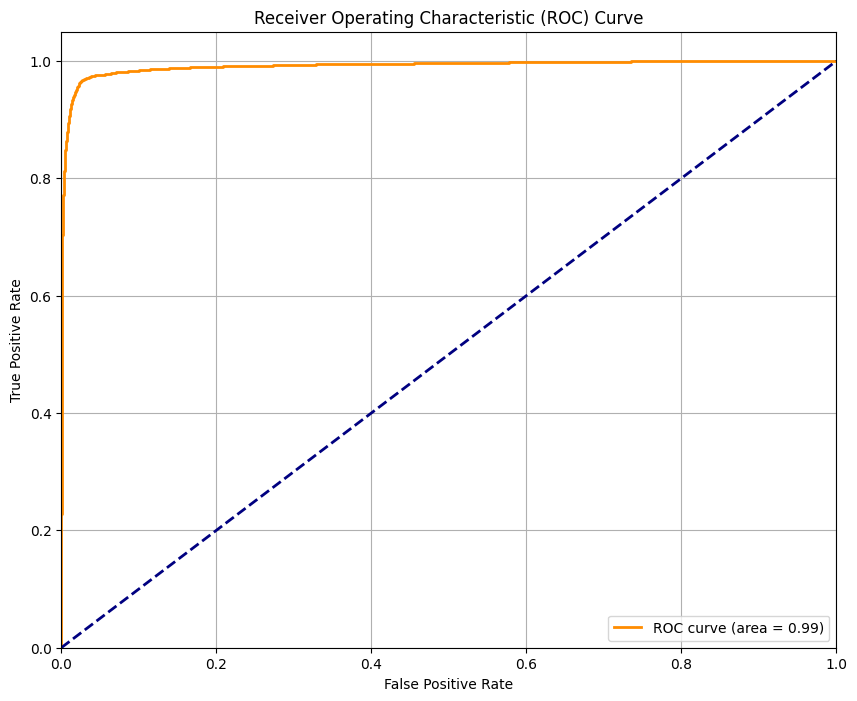

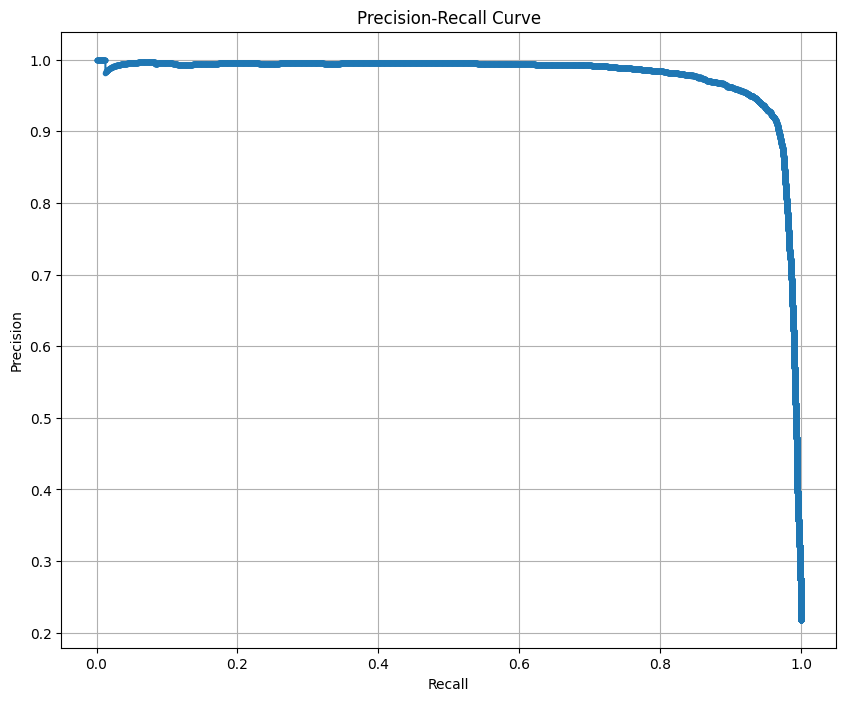

<ipython-input-8-4fa5720a586a>:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_test, palette=['lightblue', 'salmon'])


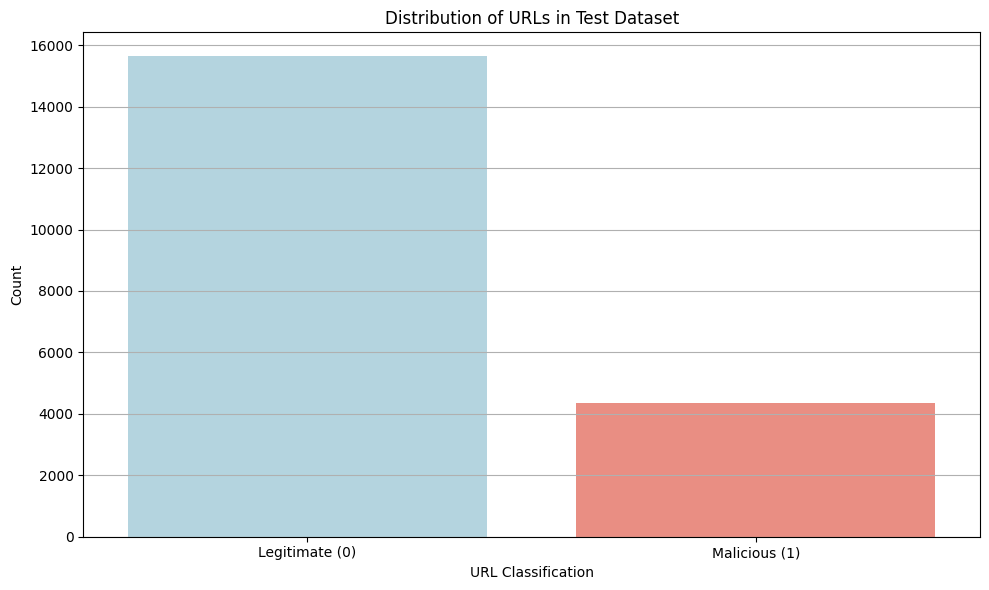

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
import seaborn as sns

# Model Evaluation Segment
y_pred = model.predict(X_test_processed)

has_proba = False
try:
    if hasattr(model, 'predict_proba'):
        y_prob = model.predict_proba(X_test_processed)[:, 1]
        has_proba = True
    elif hasattr(model, '_sigmoid'):
        linear_model = np.dot(X_test_processed, model.weights) + model.bias
        y_prob = model._sigmoid(linear_model)
        has_proba = True
except Exception as e:
    print(f"Model doesn't support probability predictions: {e}. Skipping ROC curve.")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Legitimate', 'Predicted Malicious'],
            yticklabels=['Actual Legitimate', 'Actual Malicious'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

# ROC Curve
if has_proba:
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.savefig('roc_curve.png')
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    plt.figure(figsize=(10, 8))
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.grid(True)
    plt.savefig('precision_recall_curve.png')
    plt.show()

# Distribution of Malicious vs Legitimate URLs
plt.figure(figsize=(10, 6))
sns.countplot(x=y_test, palette=['lightblue', 'salmon'])
plt.xticks([0, 1], ['Legitimate (0)', 'Malicious (1)'])
plt.title('Distribution of URLs in Test Dataset')
plt.xlabel('URL Classification')
plt.ylabel('Count')
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('class_distribution.png')
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Saving the trained logistic regression model
import joblib
import os
from IPython.display import FileLink

save_folder = '/content/drive/MyDrive/ML_Models/'
save_file = 'logistic_regression_model_for_malicious_URL_detection.joblib'
save_path = os.path.join(save_folder, save_file)


os.makedirs(save_folder, exist_ok=True)

try:
    # Saving the model
    joblib.dump(model, save_path)


    if os.path.exists(save_path):
        file_size = os.path.getsize(save_path) / (1024 * 1024)
        print(f"Model saved successfully to Google Drive as {save_path}")
        print(f"File size: {file_size:.2f} MB")
    else:
        print(f"Warning: File {save_path} was not found after saving attempt")

except Exception as e:
    print(f"An error occurred while saving the model: {e}")


    print("\nTroubleshooting tips:")
    print("1. Make sure 'model' variable is defined and contains your trained model")
    print("2. Check if you have mounted your Google Drive correctly")
    print("3. Verify you have enough disk space in your Google Drive")
    print("4. Ensure 'joblib' is properly installed (pip install joblib)")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved successfully to Google Drive as /content/drive/MyDrive/ML_Models/logistic_regression_model_for_malicious_URL_detection.joblib
File size: 0.34 MB


In [ ]:
# Saving the preprocessor
import joblib
import os

save_folder = '/content/drive/MyDrive/ML_Models/'
save_file = 'preprocessor.joblib'
save_path = os.path.join(save_folder, save_file)

os.makedirs(save_folder, exist_ok=True)

try:
    joblib.dump(preprocessor, save_path)
    if os.path.exists(save_path):
        file_size = os.path.getsize(save_path) / (1024 * 1024)
        print(f"Preprocessor saved successfully to Google Drive as {save_path}")
        print(f"File size: {file_size:.2f} MB")
    else:
        print(f"Warning: File {save_path} was not found after saving attempt")
except Exception as e:
    print(f"An error occurred while saving the preprocessor: {e}")


Preprocessor saved successfully to Google Drive as /content/drive/MyDrive/ML_Models/preprocessor.joblib
File size: 0.65 MB
